# Debugging Optimal Transport Resampling

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.models import BMModel
from pfjax.experimental.models import LotVolModelLog
import optax
from jax import lax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from pfjax.utils import logw_to_prob, continuous_cdf, interpolate_weights, argsort_marginal

In [9]:
# @partial(jax.jit, static_argnums=(2,3,))
def neg_loglik(theta, y_meas, model, key, n_particles=500, resample_fn=resampler.resample_multinomial):
    """ negative log-likelihood of PF with continuous resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resample_fn,
        history = False)
    return -ret["loglik"]


def loglik_compare (estimators, estimator_names, theta_true, theta_lims, theta_names, n_pts=100):
    """
    Return plot/df to compare log-likelihood estimators
    
    Args: 
        - estimators: list of estimators 
        - estimator_names: name of estimators used when combining the projection plots
        - plot: boolean whether or not to plot the projection plots
        - args: theta_true, theta_lims, theta_names, n_pts
    Returns
    """
    assert len(estimator_names) == len(estimators)
    df_list = []
    for i, est in enumerate(estimators):
        _proj_plot = pjp.proj_plot(
            fun=est,
            x_opt=theta_true, 
            x_lims=theta_lims, 
            x_names=theta_names, 
            n_pts=n_pts,
            vectorized=False,
            plot=False
        )
        df_list.append(_proj_plot)
        
    plot_df = pd.concat(df_list, ignore_index=True)
    plot_df["Resampler"] = np.repeat(estimator_names, _proj_plot.shape[0])
    plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})
    return plot_df

## Brownian Motion Model with Drift

\begin{align*}
    x_0 &\sim N(0, \sigma^2 \Delta t) \\
    x_t &\sim N(x_{t-1} + \mu \Delta t, \sigma^2 \Delta t) \\
    y_t &\sim N(x_t, \tau^2) \\
    \boldsymbol{\theta} &= (\mu, \sigma, \tau) 
\end{align*}

The true parameter values used are: 

\begin{align*}
\boldsymbol{\theta} &= (\mu = 0.25, \sigma = 0.5, \tau = 0.2) \\
\Delta t &= 0.1 \\ 
n &= 100 \\
x_0 &= 0
\end{align*}

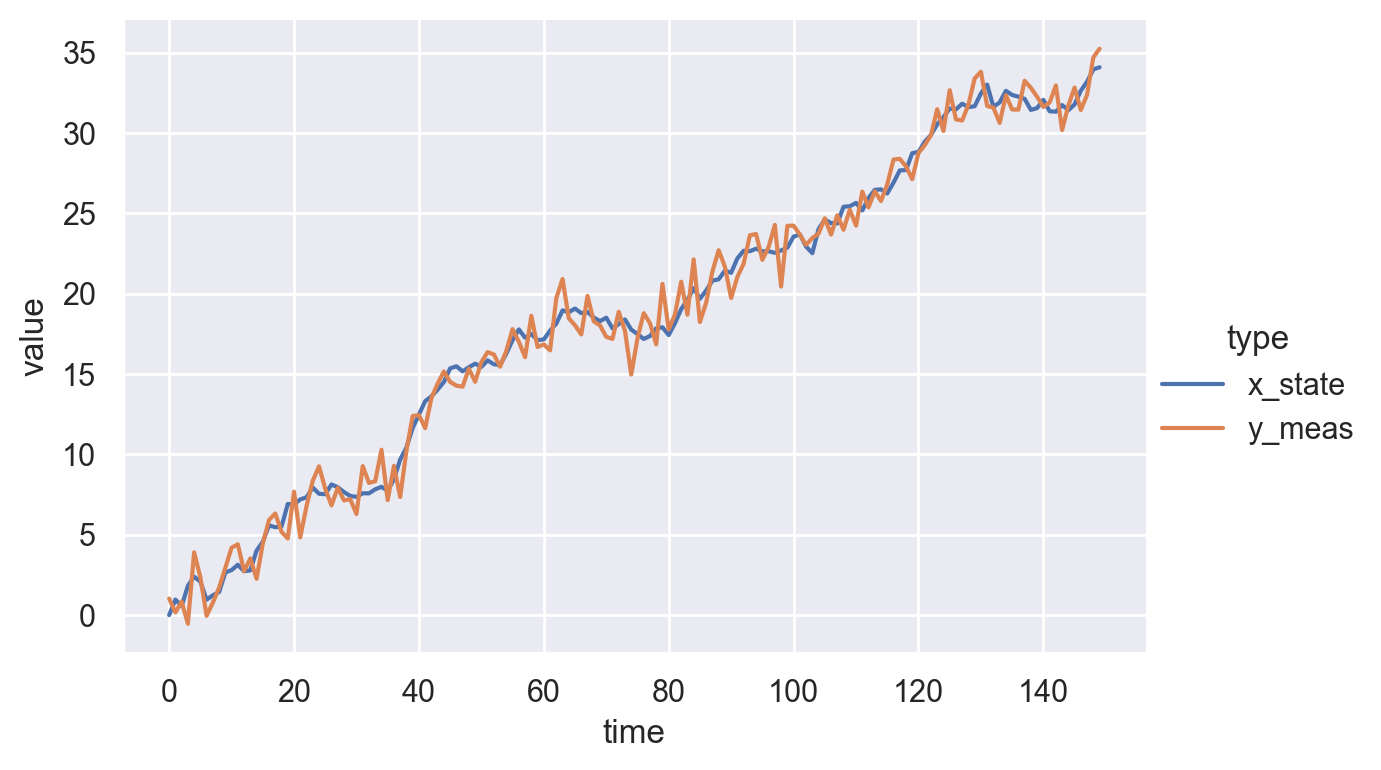

In [15]:
# parameter values
mu = 0.25
sigma = .5
tau = 1.
theta_true_bm = jnp.array([mu, sigma, tau])

# data specification
dt = 1
n_obs = 150
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas_bm, x_state_bm = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true_bm
)

# projection plot specification
n_pts = 100 # number of evaluation points per plot
theta_lims_bm = jnp.array([[-.5, 1], 
                           [.2, .9], 
                           [.75, 1.25]])  # plot limits for each parameter
theta_names_bm = ["mu", "sigma", "tau"] # parameter names

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state_bm),
                         "y_meas": jnp.squeeze(y_meas_bm)})
           .melt(id_vars="time", var_name="type"))
g = sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type",
    height=4, aspect=1.5
);

### Log-likelihood Projection Plot

In [16]:
def resample_continuous_bm (key, x_particles_prev, logw):
    """
    Continuous CDF resampler for the Brownian motion model with drift
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    prob = logw_to_prob(logw)

    sorted_marginals = argsort_marginal(x_particles_prev, prob)

    U = random.uniform(key, shape=(n_particles,))
    x_particles = jax.vmap(
        lambda u: continuous_cdf(sorted_marginals["x"], sorted_marginals["w"], u), in_axes = (0))(U)
    return {
        "x_particles": x_particles,
    }

def bm_neg_loglik_exact(theta, y_meas):
    """
    Exact negative loglikelihood of the BM model.
    """
    theta = jnp.atleast_2d(theta)
    return -jax.vmap(lambda _theta: bm_model.loglik_exact(
        y_meas=y_meas, 
        theta=_theta
    ))(theta)[0]

In [17]:
# projection plots for multinomial
n_particles_multinom = 50
n_particles_ot = 50
n_particles_mvn = 50
n_particles_gc = 50
key, subkey = jax.random.split(key)

# multinom resampling
bm_multinom = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_multinom,
    resample_fn = resampler.resample_multinomial))

# continuous CDF resampling
bm_cont = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_gc,
    resample_fn = resample_continuous_bm))

# MVN resampling
bm_mvn = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_mvn,
    resample_fn = resampler.resample_mvn))

bm_exact = jax.jit(partial(
    bm_neg_loglik_exact,
    y_meas = y_meas_bm
))

%timeit bm_multinom(theta_true_bm)
%timeit bm_exact(theta_true_bm)
%timeit bm_cont(theta_true_bm)
%timeit bm_mvn(theta_true_bm)

714 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
727 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.75 ms ± 87.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
793 µs ± 64 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
# function to create projection plots for each log-likelihood estimator:
plot_args = {
    "theta_true": theta_true_bm,
    "theta_lims": theta_lims_bm,
    "theta_names": theta_names_bm,
    "n_pts": n_pts
}

plot_df = loglik_compare(
    [bm_multinom, bm_mvn, bm_cont],
    ["Multinomial", "MVN", "Continuous"],
    **plot_args
)

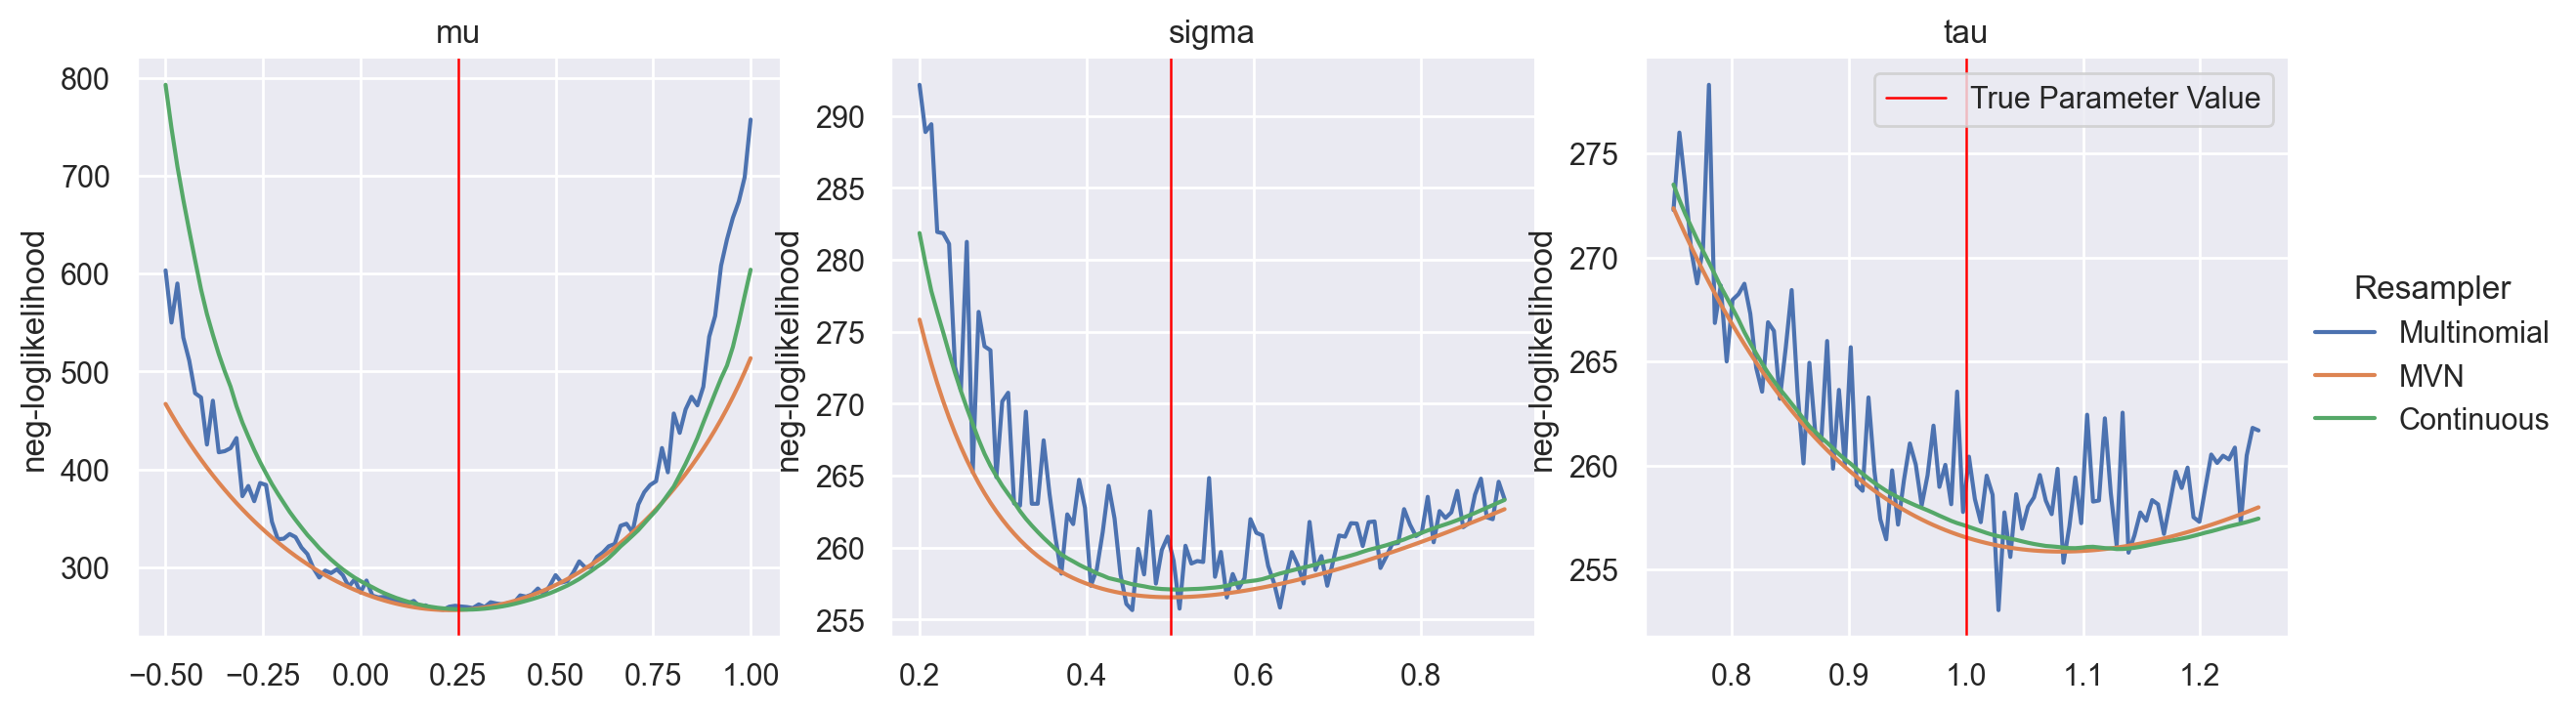

In [21]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 3,
    legend = "full",
    height=4, 
    facet_kws=dict(sharex=False, sharey=False)
)

grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta_true_bm[ind], color='red', lw = 0.9, label="True Parameter Value")

_ax.legend();

In [20]:
def resample_ot_jit(key, x_particles_prev, logw):
    return resamplers.resample_ot(key, x_particles_prev, logw, 
                                  _thresh = 0.8,
                                  pointcloud_kwargs = pointcloud_kwargs,
                                  sinkhorn_kwargs = sinkhorn_kwargs)

### Optimal Transport Tests

In [34]:
from ott.solvers.linear import sinkhorn

In [26]:
# import jax
# import jax.numpy as jnp

# import ott
# from ott.geometry import costs, pointcloud
# from ott.solvers.linear import sinkhorn
# from ott.core import linear_problems

# def create_points(rng, n, m, d):
#     rngs = jax.random.split(rng, 3)
#     x = jax.random.normal(rngs[0], (n, d)) + 1
#     y = jax.random.uniform(rngs[1], (m, d))
#     return x, y


# rng = jax.random.PRNGKey(0)
# n, m, d = 13, 17, 2
# x, y = create_points(rng, n=n, m=m, d=d)
# geom = pointcloud.PointCloud(x, x)

# # Define a linear problem with that cost structure.
# ot_prob = linear_problems.LinearProblem(geom)

# a = jnp.ones(len(x)) / len(x)

# _b = np.random.uniform(size = len(x))
# b = _b / sum(_b)

# # Create a Sinkhorn solver
# # solver = sinkhorn.Sinkhorn()
# # ot = solver(ot_prob)
# ot = sinkhorn.sinkhorn(geom, a=a, b=b, threshold = 1e-10)

# # The out object contains many things, among which the regularized OT cost
# print(
#     " Sinkhorn has converged: ",
#     ot.converged,
#     "\n",
#     "Error upon last iteration: ",
#     ot.errors[(ot.errors > -1)][-1],
#     "\n",
#     "Sinkhorn required ",
#     jnp.sum(ot.errors > -1),
#     " iterations to converge. \n",
#     "Entropy regularized OT cost: ",
#     ot.reg_ot_cost,
#     "\n",
#     "OT cost (without entropy): ",
#     jnp.sum(ot.matrix * ot.geom.cost_matrix),
# )

# plott = ott.tools.plot.Plot()
# _ = plott(ot)

 Sinkhorn has converged:  True 
 Error upon last iteration:  8.515409037623822e-11 
 Sinkhorn required  90  iterations to converge. 
 Entropy regularized OT cost:  0.254456672685757 
 OT cost (without entropy):  0.1094054240350689


In [27]:
def p_opt(f, g, x, w, eps=1):
    """
    Manually apply transport matrix using potentials f, g
    """
    def func (w, f, g, xi, xj):
        return w * jnp.exp((f + g - jnp.linalg.norm(xi - xj, ord=2))/eps)
                           
    num_particles = x.shape[0]
                           
    trans = jax.vmap(
        lambda i: jax.vmap(lambda j: func(w[i], f[i], g[j], x[i], x[j])/num_particles)(jnp.arange(num_particles))
    )(jnp.arange(num_particles))
                           
    return trans

In [29]:
# # P^{OT} JAX way: 
# jax_trans = p_opt(
#     f=jnp.array(ot.f), g=jnp.array(ot.g), 
#     x=jnp.array(x), w=jnp.array(b))

# # P^{OT} numpy way: 
# np_trans = np.zeros((len(x), len(x)))
# for i in range(len(x)):
#     for j in range(len(x)):
#         np_trans[i,j] = b[i] * jnp.exp(ot.f[i] + ot.g[j] - jnp.linalg.norm(x[i] - x[j], ord=2)) / len(x)

# np_trans - jax_trans

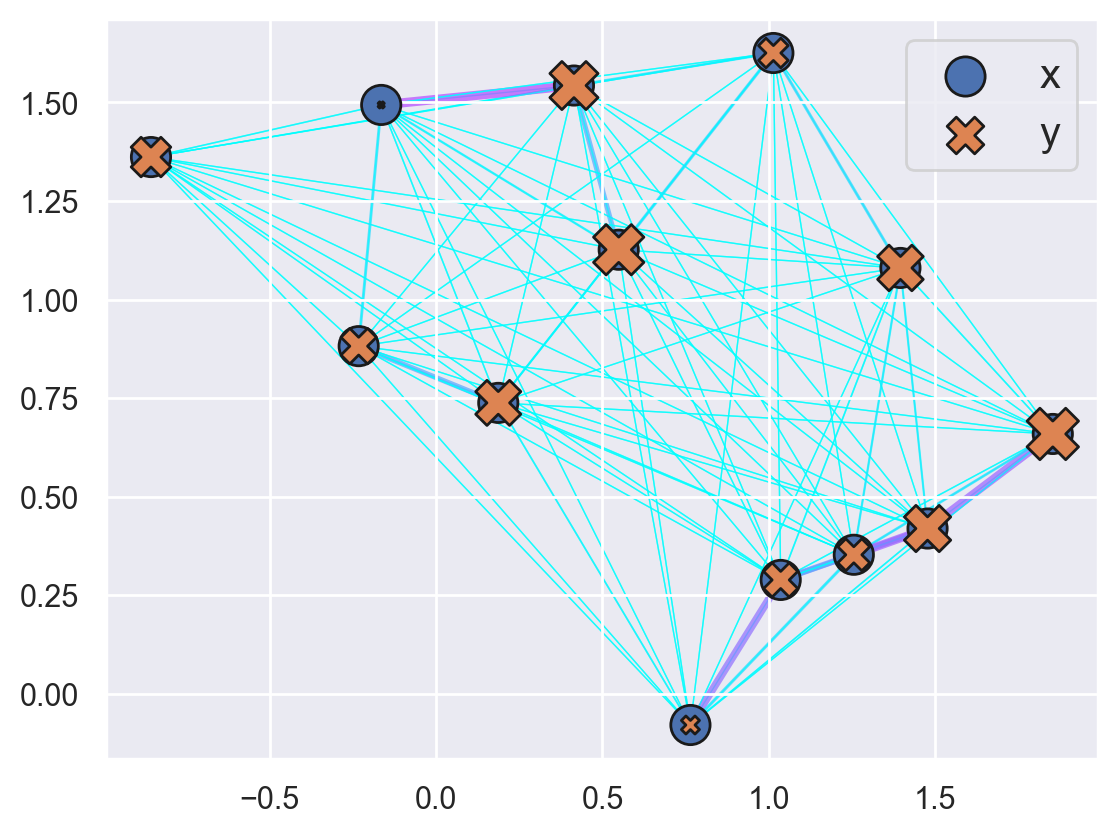

In [15]:
plott = ott.tools.plot.Plot()
_ = plott(ot)

In [31]:
def resample_ot(key, x_particles_prev, logw,
                pointcloud_kwargs={},
                sinkhorn_kwargs={}, 
                _thresh=1):
    r"""
    Particle resampler using optimal transport.

    Based on Algorithms 2 and 3 of Corenflos et al 2021 <https://arxiv.org/abs/2102.07850>.

    **Notes:**

    - Argument `jit` to `ott.sinkhorn.sinkhorn()` is ignored, i.e., always set to `False`.

    Args:
        key: PRNG key.
        x_particles_prev: An `ndarray` with leading dimension `n_particles` consisting of the particles from the previous time step.
        logw: Vector of corresponding `n_particles` unnormalized log-weights.
        pointcloud_kwargs: Dictionary of additional arguments to `ott.pointcloud.PointCloud()`.
        sinkhorn_kwargs: Dictionary of additional arguments to `ott.sinkhorn.sinkhorn()`.

    Returns:
        A dictionary with elements:
            - `x_particles`: An `ndarray` with leading dimension `n_particles` consisting of the particles from the current time step.
            - `geom`: An `ott.Geometry` object.
            - `sink`: The output of the call to `ott.sinkhorn.sinkhorn()`.
    """
    sinkhorn_kwargs.update(jit=False)
    prob = logw_to_prob(logw)
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    x_particles = x_particles_prev.reshape((n_particles, -1))
    scaled_particles = jax.lax.stop_gradient(scale_x(x_particles))
    
    geom = pointcloud.PointCloud(x=scaled_particles, 
                                 y=scaled_particles,
                                 **pointcloud_kwargs)
    sink = sinkhorn.sinkhorn(geom,
                             a=jnp.ones(n_particles)/n_particles,
                             b=prob,
                             **sinkhorn_kwargs)
    x_particles_new = sink.apply(x_particles.T)
    
    # condition for ESS resampling: 
#     x_particles_new = lax.cond(ess(prob) <= _thresh, 
#                                true_fun = lambda x: jnp.reshape(x.T, newshape=p_shape), # resmaple
#                                false_fun = lambda x: x_particles_prev, # don't resample
#                                operand = x_particles_new) 
    
    return {
        "x_particles": jnp.reshape(x_particles_new.T, newshape=p_shape), # x_particles_new,
        "geom": geom,
        "sink": sink
    }

In [58]:
def diameter(x, y):
    diameter_x = jnp.max(jnp.std(x, 1), -1)
    diameter_y = jnp.max(jnp.std(y, 1), -1)
    res = jnp.maximum(diameter_x, diameter_y)
    return jnp.where(res == 0., 1., res)


def scale_x (x):
    """
    Scale X as done in http://proceedings.mlr.press/v139/corenflos21a/corenflos21a.pdf.
    
    This replicated their code here: 
    https://github.com/JTT94/filterflow/blob/master/filterflow/resampling/differentiable/regularized_transport/plan.py#L67
    """
    centered_x = x - jnp.mean(x, axis=1, keepdims=True)
    diameter_value = diameter(x, x)
    scale = jnp.reshape(diameter_value, [-1, 1, 1]) * jnp.sqrt(x.shape[1])
    scaled_x = centered_x / scale
    return scaled_x.reshape(x.shape)


def resample_ot_test(key, x_particles_prev, logw, _thresh=0.8,
                pointcloud_kwargs={},
                sinkhorn_kwargs={}):
    
    sinkhorn_kwargs.update(jit=False)
    prob = logw_to_prob(logw)
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    x_particles = x_particles_prev.reshape((n_particles, -1))

    # scale particles: 
    scaled_particles = jax.lax.stop_gradient(scale_x(x_particles))
    
    geom = pointcloud.PointCloud(x=scaled_particles, 
                                 y=scaled_particles,
                                 **pointcloud_kwargs)
    sink = sinkhorn.sinkhorn(geom,
                             a=jnp.ones(n_particles)/n_particles,
                             b=prob,
                             **sinkhorn_kwargs)
    x_particles_new = sink.apply(x_particles.T) #* n_particles
    return {
        "x_particles": jnp.reshape(x_particles_new.T, newshape=p_shape),
        "geom": geom,
        "sink": sink
    }


# set the max_iterations to 10 to reduce runtimes
pointcloud_kwargs = {"epsilon": 0.95}
sinkhorn_kwargs = {
    "min_iterations": 0,
    "threshold": 1e-5,
    "inner_iterations":1,
    "max_iterations":1000}
n_particles_ot = 50


def ess (normalized_weights):
    """ Effective sample size from normalized weights"""
    return 1 / sum(normalized_weights ** 2)


def resample_ot_jit(key, x_particles_prev, logw):
    return resample_ot_test(key, x_particles_prev, logw, 
                            _thresh = 0.8,
                            pointcloud_kwargs = pointcloud_kwargs,
                            sinkhorn_kwargs = sinkhorn_kwargs)

In [53]:
tmp = pf.particle_filter(
    theta=theta_true_bm, 
    model=bm_model, 
    y_meas=y_meas_bm, 
    n_particles=n_particles_ot, 
    key=key,
    resampler = resample_ot_jit,
    history = True)
tmp["loglik"]

Array(-22982.68363916, dtype=float64)

In [51]:
# OT
"""
mean scaling w PointCloud: -29676.4
multiply transformed particles by n_particles: -22982.6
"""
tmp = pf.particle_filter(
    theta=theta_true_bm, 
    model=bm_model, 
    y_meas=y_meas_bm, 
    n_particles=n_particles_ot, 
    key=key,
    resampler = resample_ot_jit,
    history = True)

# Multinom
tmp_true = pf.particle_filter(
    theta=theta_true_bm, 
    model=bm_model, 
    y_meas=y_meas_bm, 
    n_particles=n_particles_ot, 
    key=key,
    history = True)

# MVNN
tmp_mvn = pf.particle_filter(
    theta=theta_true_bm, 
    model=bm_model, 
    y_meas=y_meas_bm, 
    n_particles=n_particles_ot, 
    key=key,
    resampler = resampler.resample_mvn,
    history = True)

print("OT: ", tmp["loglik"])
print("multinom: ", tmp_true["loglik"])
print("MVN: ", tmp_mvn["loglik"])

-29676.351612905608
-258.0697486733999
-260.29428456219534


In [37]:
print("Converged: ", tmp["resample_out"]["sink"].converged)
jnp.sum(tmp["resample_out"]["sink"].errors > -1, axis = 1)

Converged:  True


Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

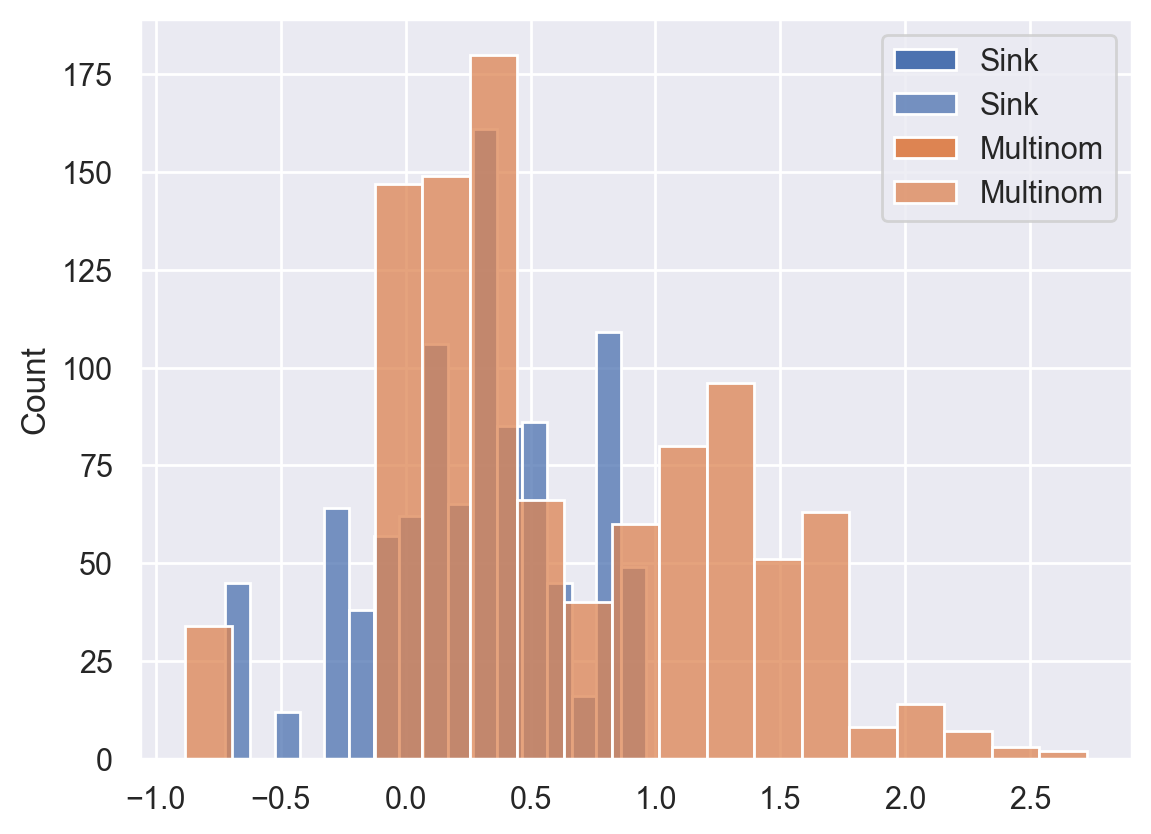

In [49]:
i = 1
p1 = jax.random.choice(
    key=subkey,
    a=tmp["x_particles"][i, :],
    shape=(10_00,), 
    replace=True,
    p=pf.utils.logw_to_prob(tmp["logw"][i, :]),
    axis=0
)

p2 = jax.random.choice(
    key=subkey,
    a=tmp_true["x_particles"][i, :],
    shape=(10_00,), 
    replace=True,
    p=pf.utils.logw_to_prob(tmp_true["logw"][i, :]),
    axis=0
)

p3 = jax.random.choice(
    key=subkey,
    a=tmp_mvn["x_particles"][i, :],
    shape=(10_00,), 
    replace=True,
    p=pf.utils.logw_to_prob(tmp_mvn["logw"][i, :]),
    axis=0
)

sns.histplot(p1, label = "Sink")
sns.histplot(p2, label="Multinom")
# sns.histplot(p3, label="MVN")
plt.legend();

In [18]:
# OTT resampling
bm_ott = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_ot,
    resample_fn = resample_ot_jit))

theta_lims_bm = jnp.array([[0.15, 0.3], 
                           [.2, 0.9], 
                           [.5, 1.5]])  # plot limits for each parameter

plot_args_bm = {
    "theta_true": theta_true_bm,
    "theta_lims": theta_lims_bm,
    "theta_names": theta_names_bm,
    "n_pts": 50
}

plot_df = loglik_compare(
    [bm_exact, bm_multinom, bm_mvn, bm_cont, bm_ott],
    ["Exact", "Multinomial", "MVN", "Continuous", "Optimal Transport"],
    **plot_args_bm
)

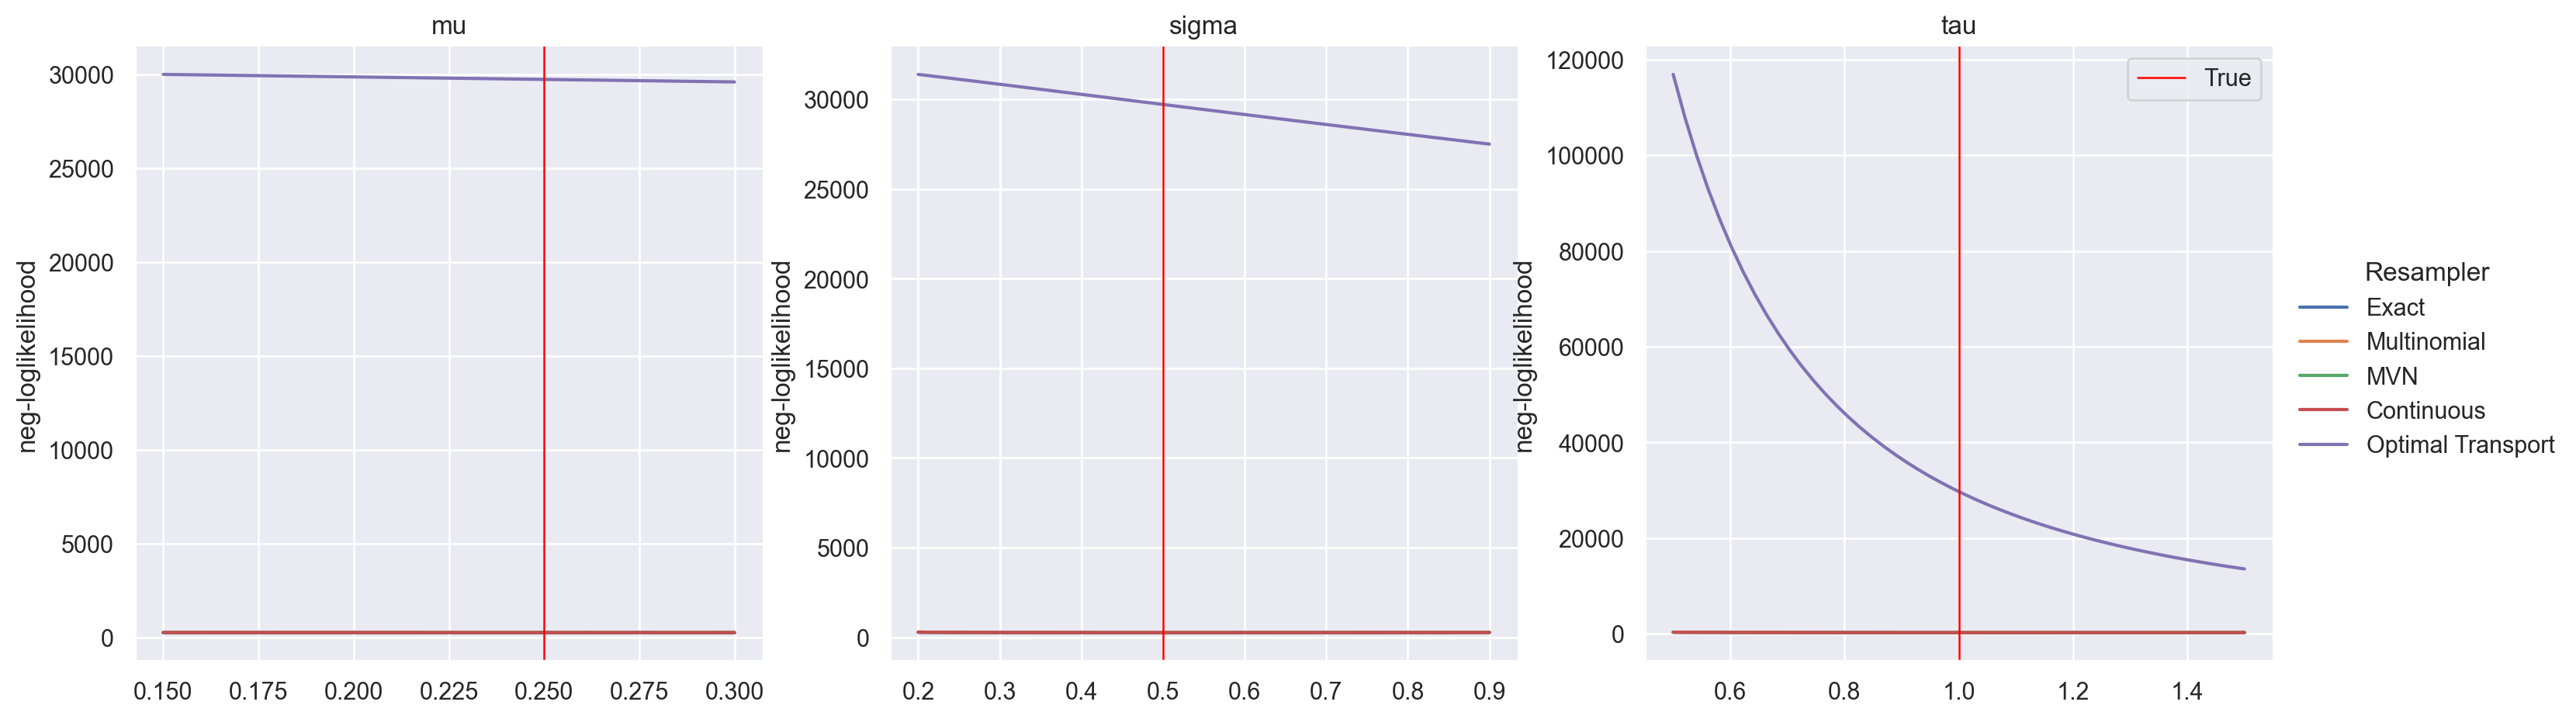

In [19]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)

grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta_true_bm[ind], color='red', lw = 0.9, label="True")
_ax.legend();

### Compare with filterflow sinkhorn

In [ ]:
def sinkhorn_loop(log_alpha, log_beta, cost_xy, cost_yx, cost_xx, cost_yy, epsilon, particles_diameter, scaling,
                  threshold, max_iter):
    batch_size = log_alpha.shape[0]
    continue_flag = tf.ones([batch_size], dtype=bool)
    epsilon_0 = particles_diameter ** 2
    scaling_factor = scaling ** 2

    a_y_init = softmin(epsilon_0, cost_yx, log_alpha)
    b_x_init = softmin(epsilon_0, cost_xy, log_beta)

    a_x_init = softmin(epsilon_0, cost_xx, log_alpha)
    b_y_init = softmin(epsilon_0, cost_yy, log_beta)

    def stop_condition(i, _a_y, _b_x, _a_x, _b_y, continue_, _running_epsilon):
        n_iter_cond = i < max_iter - 1
        return tf.logical_and(n_iter_cond, tf.reduce_all(continue_))

    def apply_one(a_y, b_x, a_x, b_y, continue_, running_epsilon):
        running_epsilon_ = tf.reshape(running_epsilon, [-1, 1])
        continue_reshaped = tf.reshape(continue_, [-1, 1])
        # TODO: Hopefully one day tensorflow controlflow will be lazy and not strict...
        at_y = tf.where(continue_reshaped, softmin(running_epsilon, cost_yx, log_alpha + b_x / running_epsilon_), a_y)
        bt_x = tf.where(continue_reshaped, softmin(running_epsilon, cost_xy, log_beta + a_y / running_epsilon_), b_x)

        at_x = tf.where(continue_reshaped, softmin(running_epsilon, cost_xx, log_alpha + a_x / running_epsilon_), a_x)
        bt_y = tf.where(continue_reshaped, softmin(running_epsilon, cost_yy, log_beta + b_y / running_epsilon_), b_y)

        a_y_new = (a_y + at_y) / 2
        b_x_new = (b_x + bt_x) / 2

        a_x_new = (a_x + at_x) / 2
        b_y_new = (b_y + bt_y) / 2

        a_y_diff = tf.reduce_max(tf.abs(a_y_new - a_y), 1)
        b_x_diff = tf.reduce_max(tf.abs(b_x_new - b_x), 1)

        local_continue = tf.logical_or(a_y_diff > threshold, b_x_diff > threshold)
        return a_y_new, b_x_new, a_x_new, b_y_new, local_continue

    def body(i, a_y, b_x, a_x, b_y, continue_, running_epsilon):
        new_a_y, new_b_x, new_a_x, new_b_y, local_continue = apply_one(a_y, b_x, a_x, b_y, continue_,
                                                                       running_epsilon)
        new_epsilon = tf.maximum(running_epsilon * scaling_factor, epsilon)
        global_continue = tf.logical_or(new_epsilon < running_epsilon, local_continue)

        return i + 1, new_a_y, new_b_x, new_a_x, new_b_y, global_continue, new_epsilon

    n_iter = tf.constant(0)

    total_iter, converged_a_y, converged_b_x, converged_a_x, converged_b_y, _, final_epsilon = tf.while_loop(
        stop_condition,
        body,
        loop_vars=[n_iter,
                   a_y_init,
                   b_x_init,
                   a_x_init,
                   b_y_init,
                   continue_flag,
                   epsilon_0])

    converged_a_y, converged_b_x, converged_a_x, converged_b_y, = tf.nest.map_structure(tf.stop_gradient,
                                                                                        (converged_a_y,
                                                                                         converged_b_x,
                                                                                         converged_a_x,
                                                                                         converged_b_y))
    epsilon_ = tf.reshape(epsilon, [-1, 1])
    final_a_y = softmin(epsilon, cost_yx, log_alpha + converged_b_x / epsilon_)
    final_b_x = softmin(epsilon, cost_xy, log_beta + converged_a_y / epsilon_)
    final_a_x = softmin(epsilon, cost_xx, log_alpha + converged_a_x / epsilon_)
    final_b_y = softmin(epsilon, cost_yy, log_beta + converged_b_y / epsilon_)

    return final_a_y, final_b_x, final_a_x, final_b_y, total_iter + 2


def sinkhorn_potentials(log_alpha, x, log_beta, y, epsilon, scaling, threshold, max_iter):
    cost_xy = cost(x, tf.stop_gradient(y))
    cost_yx = cost(y, tf.stop_gradient(x))
    cost_xx = cost(x, tf.stop_gradient(x))
    cost_yy = cost(y, tf.stop_gradient(y))
    scale = tf.stop_gradient(max_min(x, y))
    a_y, b_x, a_x, b_y, total_iter = sinkhorn_loop(log_alpha, log_beta, cost_xy, cost_yx, cost_xx, cost_yy, epsilon,
                                                   scale, scaling, threshold, max_iter)

    return a_y, b_x, a_x, b_y, total_iter

### Score Function Estimate

In [170]:
# # score function for different resampling schemes: 
bm_loglik = partial(neg_loglik, model=bm_model, y_meas = y_meas_bm)
bm_score_exact = jax.jit(jax.grad(partial(bm_neg_loglik_exact, y_meas=y_meas_bm)))

# multinomial resampling:
@partial(jax.jit, static_argnums=(2,))
def bm_score_multinom(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles)

# MVN resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_mvn(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles, 
                               resample_fn = pf.particle_resamplers.resample_mvn)

# continuous CDF resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_cont(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles, 
                               resample_fn = resample_continuous_bm)

# continuous CDF resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_ot(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles, 
                               resample_fn = resample_ot_jit)

In [171]:
bm_score_ot(theta_true_bm, subkeys[i], n_particles=n_particles)

DeviceArray([-250.52623838,  219.03822051,   13.41024178], dtype=float64)

In [172]:
key = random.PRNGKey(0)
n_particles = 100
n_sim = 15
key, *subkeys = random.split(key, n_sim+1)

# repeat calculation nsim times
score_exact = bm_score_exact(theta_true_bm)
score_multinom = []
score_mvn = []
score_cont = []
score_ot = []

for i in range(n_sim):
    score_ot += [bm_score_ot(theta_true_bm, subkeys[i], n_particles=n_particles)]
    score_multinom += [bm_score_multinom(theta_true_bm, subkeys[i], n_particles=n_particles)]
    score_mvn += [bm_score_mvn(theta_true_bm, subkeys[i], n_particles=n_particles)]
    score_cont += [bm_score_cont(theta_true_bm, subkeys[i], n_particles=n_particles)]

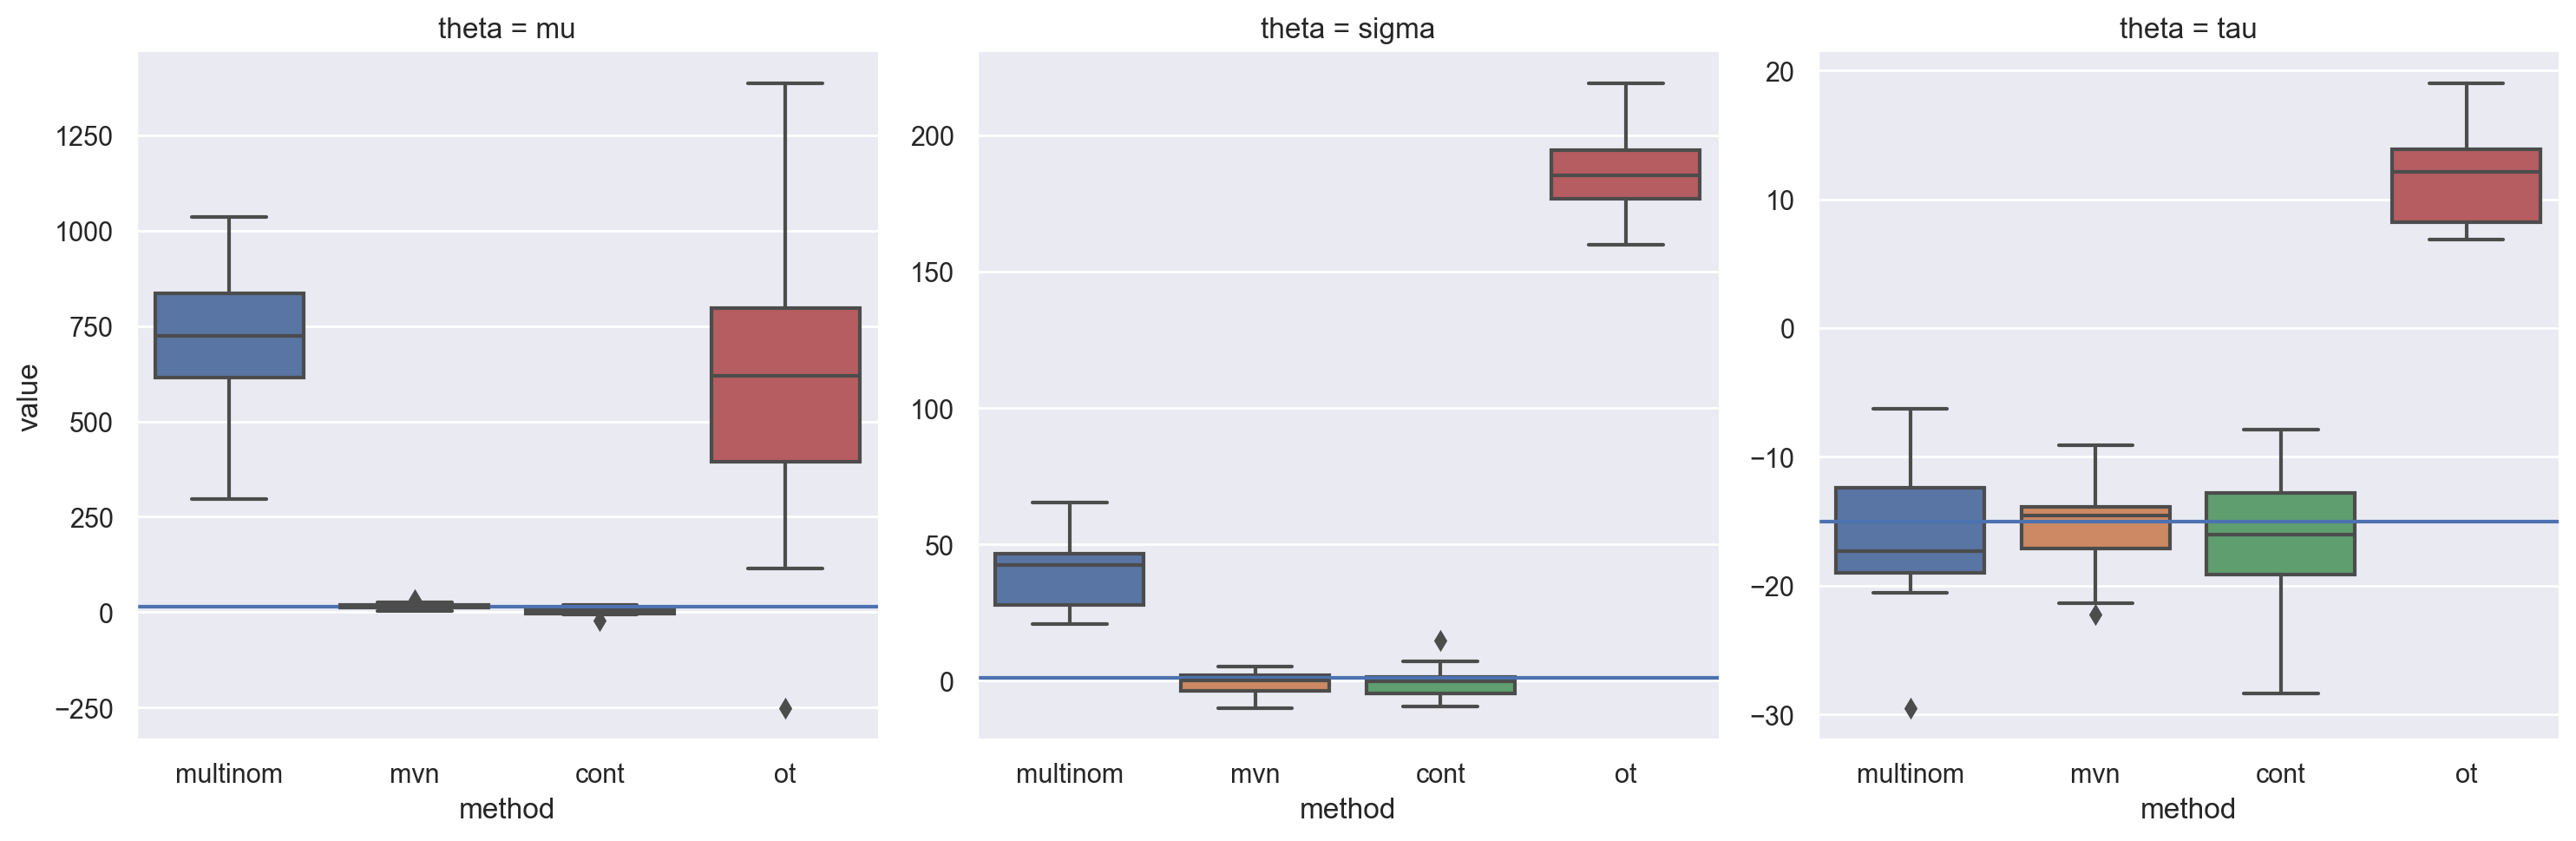

In [173]:
score_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names_bm, n_sim),
    "multinom": np.array(score_multinom).ravel(),
    "mvn": np.array(score_mvn).ravel(),
    "cont": np.array(score_cont).ravel(),
    "ot": np.array(score_ot).ravel()
})
    .melt(id_vars=["theta"], value_vars=["multinom", "mvn", 
                                         "cont", "ot"], var_name="method")
)

g = sns.catplot(
    data=score_df,
    kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(score_exact[i]) for i in range(theta_true_bm.size)];

## Optimal Transport for LotVol

In [18]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta_true_lv = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names_lv = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims_lv = jnp.log(jnp.array([
    [0.7  , 1.2],
    [0.9  , 1.1],
    [3.9  , 4.1],
    [0.9  , 1.1],
    [0.01 , 0.4],
    [0.01 , 0.4],
    [0.2, 0.4],
    [0.2, 0.3]]))

dt = 0.1
n_res = 1
n_obs = 100

key = random.PRNGKey(0)
key, subkey = random.split(key)

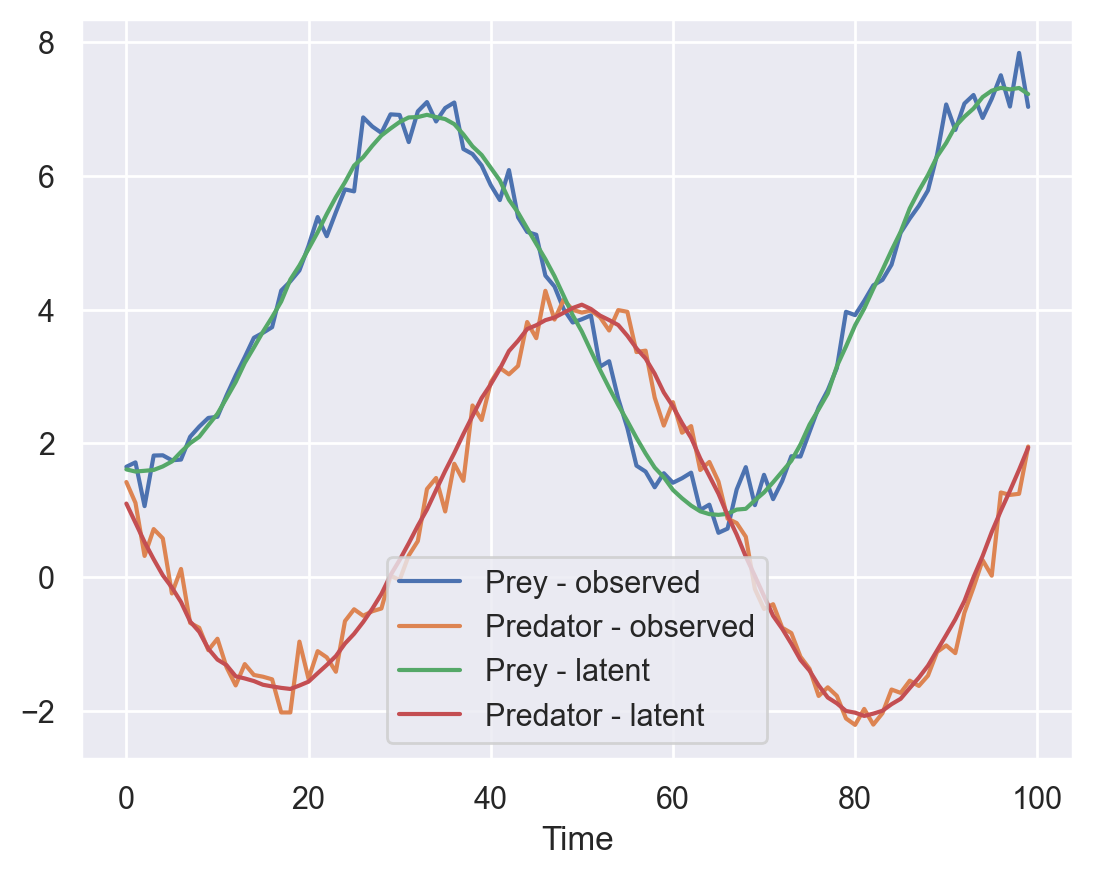

In [19]:
lotvol_model = LotVolModelLog(dt, n_res, bootstrap = True) 
theta_true_lv = jnp.log(theta_true_lv)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_lv, x_state_lv = pf.simulate(
    model = lotvol_model, 
    n_obs = n_obs, 
    x_init = x_init, 
    theta = theta_true_lv, 
    key = subkey)

# plt.plot(jnp.exp(y_meas_lv.squeeze()[:, 0]), label = "Prey - observed")
# plt.plot(jnp.exp(y_meas_lv.squeeze()[:, 1]), label = "Predator - observed")
# plt.plot(jnp.exp(x_state_lv.squeeze()[:, 0]), label = "Prey - latent")
# plt.plot(jnp.exp(x_state_lv.squeeze()[:, 1]), label = "Predator - latent")

plt.plot(y_meas_lv.squeeze()[:, 0], label = "Prey - observed")
plt.plot(y_meas_lv.squeeze()[:, 1], label = "Predator - observed")
plt.plot(x_state_lv.squeeze()[:, 0], label = "Prey - latent")
plt.plot(x_state_lv.squeeze()[:, 1], label = "Predator - latent")
plt.xlabel("Time")
plt.legend();

In [20]:
# projection plots for multinomial
n_particles = 200
key, subkey = jax.random.split(key)

# multinom resampling
lv_multinom = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles,
    resample_fn = resampler.resample_multinomial))

# continuous CDF resampling
lv_gc = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles,
    resample_fn = resampler.resample_gaussian_copula))

# MVN resampling
lv_mvn = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles,
    resample_fn = resampler.resample_mvn))

In [21]:
tmp = pf.particle_filter(
    theta=theta_true_lv, 
    model=lotvol_model, 
    y_meas=y_meas_lv, 
    n_particles=n_particles_ot, 
    key=key,
    resampler = resample_ot_jit,
    history = True)

tmp_true = pf.particle_filter(
    theta=theta_true_lv, 
    model=lotvol_model, 
    y_meas=y_meas_lv, 
    n_particles=n_particles_ot, 
    key=key,
    history = True)

tmp_mvn = pf.particle_filter(
    theta=theta_true_lv, 
    model=lotvol_model, 
    y_meas=y_meas_lv, 
    n_particles=n_particles_ot, 
    key=key,
    resampler = resampler.resample_mvn,
    history = True)

print(tmp["loglik"])
print(tmp_true["loglik"])
print(tmp_mvn["loglik"])

-72.2166552553976
-28.45115671602582
-29.21328750916416


In [22]:
# OTT resampling
lv_ot = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles,
    resample_fn = resample_ot_jit))

plot_args_bm = {
    "theta_true": theta_true_lv,
    "theta_lims": theta_lims_lv,
    "theta_names": theta_names_lv,
    "n_pts": 50
}

plot_df = loglik_compare(
    [lv_multinom, lv_mvn, lv_gc, lv_ot],
    ["Multinomial", "MVN", "Continuous", "Optimal Transport"],
    **plot_args_bm
)

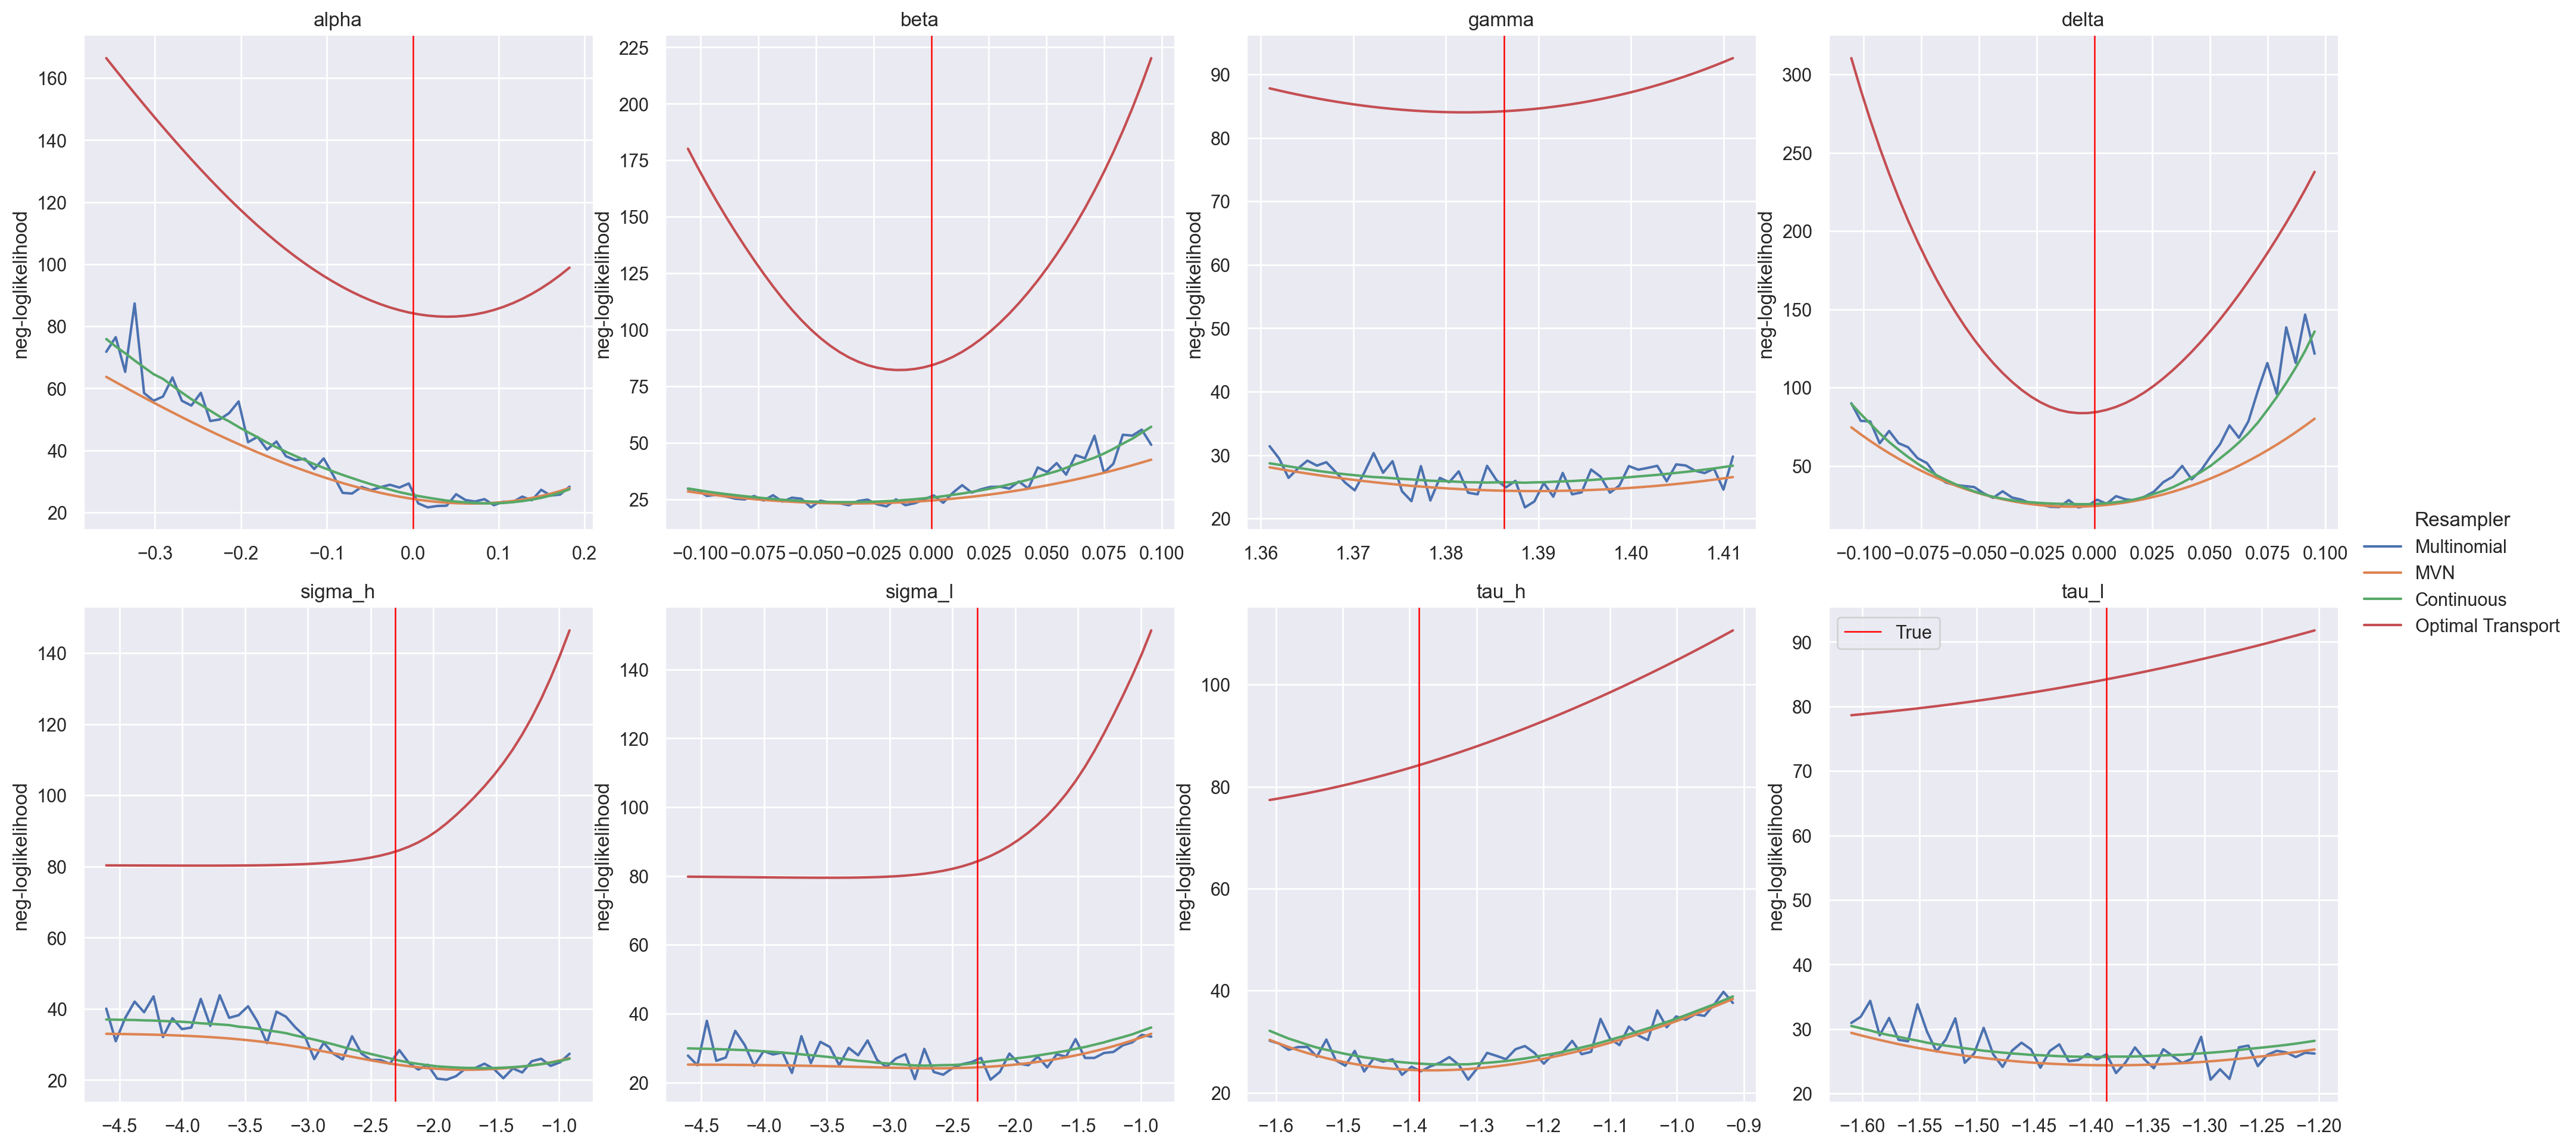

In [23]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta_true_lv[ind], color='red', lw = 0.9, label="True")
_ax.legend();